In [13]:
# -*- coding: utf-8 -*-
"""
Titulo: Automatizacion reportes regionales
Created on Thu Aug 22 11:58:39 2019

Proceso que automatiza reportes regionales, generando un documento word por cada region.

Obs: Se deben revisar los inputs antes de correr

@author: hugo.gallardo
"""

# =============================================================================
# Extracción en python de datos de comunicado de compras a nivel regional
# =============================================================================

#Seteo de librerias

import pandas as pd
import numpy as np
import sqlalchemy as sa              #Para conexión a BD, requerido para usar pd.read_sql()
import urllib                        #Para formatear string de conexión

import docx
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import openpyxl as opxl             # OJO EN LA CASA para importar excel como dataframe

from docx import Document
from docx import shared
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.text import WD_LINE_SPACING
from docxtpl import DocxTemplate, InlineImage   #rellenar templates

import seaborn as sns
import os
import sys
from pylab import savefig
import itertools

import pyodbc                               ### another engine to make DB connection and run the queries. Alternative to sqlalchemy
from itertools import repeat
import querysGR as qg

In [14]:
import sqlalchemy as sa 
import urllib 
import pyodbc 

import docx
import pandas as pd
import matplotlib.pyplot as plt 
import openpyxl as opxl 

from docx import Document
from docxtpl import DocxTemplate, InlineImage 
import os

In [15]:
#Transforma codigo a word
#Agregar github


#Conexion a DW

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#A DCCPProcurement
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.145;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)


#**** BBDD *****

# Verificar Drivers

###### DW ######

param_DW = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional;TrustServerCertificate=yes")
conn_DW = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_DW)


##### DEV #####

param_dev = urllib.parse.quote_plus("DRIVER={/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.2.so.2.1};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022;TrustServerCertificate=yes")
conn_dev = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_dev)

##### AQUILES #####

param_AQ = urllib.parse.quote_plus("DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes")
conn_AQ = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_AQ)

### connections with pyodbc ###
conn_AQ_pyodbc=pyodbc.connect('DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes')#;Encrypt=yes')#;TrustServerCertificate=yes')#;TrustServerCertificate=yes')
#conn_AQ_pyodbc = pyodbc.connect('DRIVER={SQL Server};SERVER=10.34.71.146;DATABASE=DCCPProcurement;UID=datawarehouse;PWD=datawarehouse')
cursor=conn_AQ_pyodbc.cursor()
#*************************

In [16]:
# =============================================================================
# Creando parametros y funciones para queries 
# =============================================================================


#ulr no se está usando porque se trabaja con ubicación de .ipynb como referencia
#url = 'C:/o/OneDrive - DCCP/Escritorio/Dpt Comunicaciones/Reportes Automatizados'

#Llamar funcion que define ruta




#entra numero y retorna valor con puntos en string
#abrevia en millones si supera 8 dígitos
#agrega símbolos monetarios
def fmtoEntero(x, mnd=''):
    ini = ''
    fin = ''

    #abrevia si supera 8 digitos
    if x >= 100000000: #me pareció que muestre al menos 3 dígitos
        x = x / 1000000
        fin = ' millones'
    
    #verificar formato de escritura
    if mnd == 'CLP':
        ini = '$'
    elif mnd == 'USD':
        ini = 'US $'
        #fin = fin + ' USD'
    elif mnd == 'CLF':
        if fin == ' millones':
            fin = fin + ' de UF'
        else:
            fin = fin + ' UF'
    
    x = format(int(round(x)),',d') #crea str de entero con puntuación
    x = x.replace(",",".") #formato de puntos latino

    return ini + x + fin


#entra tasa y retorna el porcentaje como string
def fmtoPorcien(x):
    x = x * 100
    x = format(x,',.1f') #crea str con 1 decimal y puntuación
    x = x.replace(".","a").replace(",",".").replace("a",",") #formato de puntos latino
    return x+'%'


#Agrega gráfico de torta, necesita datos (x), etiqueta (labels) y título (titGraf)
def grafTorta(x, labels, titGraf): 
    plt.clf()
    
    fig, ax = plt.subplots(figsize =(10, 9))
    #plt.figure(figsize=(4.5,4.5))
    bordeG = {'linewidth' : 1, 'edgecolor' : 'white'}
    plt.pie(x
            , autopct='%.1f%%'
            , textprops=dict(color="grey", size=10)
            , pctdistance=1.15
            , wedgeprops = bordeG)
    legend = plt.legend(labels
                        , loc = "lower center"
                        , bbox_to_anchor=(0.27, -0.15, 0.5, 0.5)
                        , ncols = 3
                        , fontsize=10
                        , handlelength=0.7
                        , handleheight=0.7
                        ) 
    tituloG = plt.title(titGraf ,fontweight="bold",fontsize=16)

    
    plt.savefig(titGraf+'.png')

#Crea gráfico de barras horizontal, necesita datos (x), etiqueta (labels) y título (titulo)
def grafBarras(x, labels, titulo):
    plt.clf()
    fig, ax = plt.subplots(figsize =(16, 9))
    
    # Horizontal Bar Plot
    ax.barh(labels, x)
    
    # Remove axes splines
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    #ax.xaxis.set_ticks_position('none')
    #ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    
    # Add x, y gridlines
    ax.grid(#b = True, 
            color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
    
    # Show top values 
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5, 
                str(round((i.get_width()), 2)),
                fontsize = 15, fontweight ='bold',
                color ='grey')
    
    # Add Plot Title
    ax.set_title(titulo,
                loc ='left', 
                fontsize = 25)
    
    # Add Text watermark
    fig.text(0.9, 0.15, 'ChileCompra', fontsize = 12,
            color ='grey', ha ='right', va ='top',
            alpha = 0.7)
    plt.style.use('seaborn-v0_8-darkgrid')
    # Show Plot
    plt.savefig(titulo+'.png')


#retorna string aumento/disminución según variacón numérica entregada
def palabraVar(var):
    plb = 'una no variación' #es necesario?
    if var > 0:
        plb = 'un aumento'
    elif var < 0:
        plb = 'una disminución'
    return plb



############################################################################################
###    Definición funciones creación diccionarios y contexto para llenado de template    ###
############################################################################################



#Settea diccionario contexto regional
def setContextoReg(r):
    ctxt = {}
    ctxt.update(RegNomb[r])
    return ctxt



#Retorna diccionario con total transado de monto y OC por región
#(dataframe filtrado por región, moneda a usar)
def agregarTotalesRegion(df):
    nctxt = {}
    
    regMndUSD   = df.loc[df['Año'] == anoReg, 'Monto_Bruto_USD'].iloc[0]     
    regMnd      = df.loc[df['Año'] == anoReg, 'Monto_Bruto_'+'CLP'].iloc[0]     
    regOC       = df.loc[df['Año'] == anoReg, 'CantOC'].iloc[0]               
    regMndM     = df.loc[df['Año'] == anoRegM, 'Monto_Bruto_'+'CLP'].iloc[0]    
    regOCM      = df.loc[df['Año'] == anoRegM, 'CantOC'].iloc[0]              

    nctxt['totRegUSD']      = fmtoEntero( regMndUSD , 'USD')
    nctxt['totReg'+'CLP']     = fmtoEntero( regMnd    , 'CLP')
    nctxt['totRegOC']       = fmtoEntero( regOC     )
    nctxt['totReg'+'CLP'+'M'] = fmtoEntero( regMndM   , 'CLP')
    nctxt['totRegOCM']      = fmtoEntero( regOCM    )
    
    tasaVar                 = (regMnd - regMndM) / regMndM
    nctxt['totRegPct']      = fmtoPorcien(tasaVar)
    nctxt['totRegVarPlb']   = palabraVar(tasaVar)

    return nctxt



#Llama a creación de gráfico y retorna diccionario para agregarlo a template
#¿Pide moneda o dejamos default?
def agregarGrafMontoSectorRegion(df, titGraf):
    
    grafTorta(df['CLP'], df[''], titGraf)
    #pedir docu como parametro?
    img = InlineImage(docu, titGraf+'.png',width=Inches(6))
    dctGrf = {'secRegGrf' : img}
    return dctGrf



def agregarCARegion(df): 
    nctxt = {}

    # Dataframes año actual y anterior
    df0 = df.loc[df['Ano'] == anoReg] #MONTOCLP_CAg  MONTOUSD_CAg  CantOC_CAg
    dfM = df.loc[df['Ano'] == anoRegM]

    mto0    = df0['MONTOCLP_CAg'].iloc[0]
    oc0     = df0['CantOC_CAg'].iloc[0]
    mtoM    = dfM['MONTOCLP_CAg'].iloc[0]
    ocM     = dfM['CantOC_CAg'].iloc[0]

    mtoVar  = (mto0 - mtoM)/ mtoM   #Variacion monto
    ocDif   = oc0 - ocM             #Diferencia cantidad OC
    
    nctxt['caReg'+'CLP']       = fmtoEntero(mto0, 'CLP')
    nctxt['caRegOC']         = fmtoEntero(oc0)
    nctxt['caReg'+'CLP'+'M']   = fmtoEntero(mtoM, 'CLP')
    nctxt['caRegOCM']        = fmtoEntero(ocM)
    nctxt['caReg'+'CLP'+'Var'] = fmtoPorcien(mtoVar)
    nctxt['caRegOCDif']      = fmtoEntero(ocDif)

    return nctxt



def extraerDataframe (df, r, listCol):
    df = df.loc[df['Region'] == r]
    listCol = ['Ano', 'Region'] + listCol
    
    df = df.groupby(listCol).agg({'USD' : sum,
                                  'CLP' : sum,
                                  'CLF' : sum,
                                  'OC'  : sum,})
    
    return df



def fmtoDataframe (df, listCol):
    df = df.reset_index()                               #reincorporar columnas del index
    df = df[df['Ano'] == 2023]                          #revisar cuando se usen mas años
    df = df.sort_values(by = 'USD', ascending = False)  #asegurar orden top
    df = df.reset_index()                               #reenumerar index
    df = df.rename(columns = {listCol[0] : ''})         #formatea nombre de columna con dato de interés
    #######################################
    # BORRAR COLUMNAS AÑO, REGION E INDEX #
    #######################################
    return df



#Función para transformar dataframe filtrado en diccionario.
    #df: Dataframe filtrado por región, año y columnas necesarias. Columna principal se reconoce  como '' (pd.df)
    #dto: nombre del dato de la sección que se trabaja. Ej: Rubro por región -> 'rubReg' (string)
    #top: cantidad de filas a procesar de las con mayores montos, por defecto 15. Se recomienda usar el 15 (int)
def dataframeDiciconario (df, dto, top=15):
    
    #Crea el diccionario a retornar
    nctxt = {}

    #Calcula  el monto total en la región. Se usa como referencia para porcentajes
    tot = df['CLP'].sum()
    #Agrega al diccionario el total en formato legible como dinero. Útil para verificar con totales de otros grupos de datos
    nctxt[dto+'TOTAL'] = fmtoEntero(tot, 'CLP') 

    #Comparala candtidad de filas disponibles vs la solicitada con 'top', deja la cantidad menor para iterar..
    if top > df.shape[0]:
        print('Cantidad de datos es menor a la requerida. ('+dto+')')
    top = min(top, df.shape[0]) #para que top no sea mayor a cantidad de datos

    #Filtra el df dejando los n valores mayores. n = top
    df = df.head(top)

    #Iterar el df celda por celda
    #Iterador de filtas. i (el index) indica el lugar en el top - 1 (parte desde el 0). row contiene todos los datos relacionados a la posición
    for i,row in df.iterrows():
        
        #Iterador de columnas. colu indica la columna o dato de la fila.
        for colu in df.columns:

            #Para explicar dto + colu + str(i1)
            #Se usa 'dto', 'colu' e 'i' para nombrar la clave del diccionario y que coincida con los parámetros de las variables en el template
                #Si estamos trabajando las modalidades de compra (dto = 'modReg')
                #Si estamos en la fila 3, la tercera modalidad con mas monto transado (i = 2)
                #Y se entra a la columna de cantidad OC involucradas (colu = 'OC')
                #La clave será 'modRegOC3', de cantidad de OC en la tercera modadlidad de compra de mayor monto transado
                #
                #Mismo caso, pero se entra a la columna que indica la modalidad. Al se la columna principal se identifica colu = ''
                #Clave 'modReg3', tercera modalidad de compra con mayor montro tranzado
            
            #El if reconoce si la celda es un número a formatear con fmtoEntero(), lo cual ocurre con las columnas 'USD', 'CLP', 'CLF', 'OC'
            if colu in ['USD', 'CLP', 'CLF', 'OC']:
                #Si cumple, guarda en el diccionario como lista
                nctxt[dto+colu+str(i+1)]     = [row[colu], colu]
            else:
                #Si no, guarda el valor normalmente
                nctxt[dto+colu+str(i+1)]     = row[colu]

        #Usando el total calculado al principio de la función (con CLP), se usa el valor CLP de la fila para calcular su porcentaje
            #respecto al total,  y lo argega al diciconario
            #Se hace fuera del iterador de columnas porque este valor no tiene columna calculada 
        nctxt[dto+'Pct'+str(i+1)]   = fmtoPorcien((row['CLP']/tot)) 

    #Recorre todo el diccionario resultante en busca de valores numéricos a formatear (poner puntos y símbolos de moneda con fmtoEntero())
    for clave, valor in nctxt.items():

        #Si el valor encontrado es una lista entonces es un valor a formatear. El primer elemenro es el número y el segundo su unidad
            #simpremente remplaza la lista por el falor ya formateado
            #Ej: [1000999000,4  ,  'USD'] -> 'US $1.001 millones'
        if type(valor) == list:
            nctxt[clave] = fmtoEntero(valor[0], valor[1])
    
    #Retorna el diccionario creado a partir del dataframe
    return nctxt



#Importa datos especificados por solicitante para cada región, retorna un diccionario de diccionarios regionales con los datos
def impAdicionalesReg ():
    addReg = pd.read_excel(io = 'datosAdicionales.xlsx') #requiere también openpyxl
    return addReg.set_index('region').to_dict('index')


In [17]:
# =============================================================================
# Setteo Diccionarios Regionales y Nacional
# =============================================================================
                                  
# Diccionario Regional, adaptar nombres de BBDD
# Usar BBDD? Renombrar para diccionario con mas datos??
RegNomb =  {'Antofagasta':              {'nom':'Región de Antofagasta',                  'nomCt':'Antofagasta'},
            'Araucanía':                {'nom':'Región de La Araucanía',                 'nomCt':'La Araucanía'},
            'Arica y Parinacota':       {'nom':'Región de Arica y Parinacota',           'nomCt':'Arica y Parinacota'},
            'Atacama':                  {'nom':'Región de Atacama',                      'nomCt':'Atacama'},
            'Aysén':                    {'nom':'Región de Aysén',                        'nomCt':'Aysén'},
            'Bío-Bío':                  {'nom':'Región del Bío-Bío',                     'nomCt':'el Bío-Bío'},
            'Coquimbo':                 {'nom':'Región de Coquimbo',                     'nomCt':'Coquimbo'},
            "Lib. Gral. Bdo. O'Higgins":{'nom':"Región de O'Higgins",                    'nomCt':"O'Higgins"},
            'Los Lagos':                {'nom':'Región de Los Lagos',                    'nomCt':'Los Lagos'},
            'Los Ríos':                 {'nom':'Región de Los Ríos',                     'nomCt':'Los Ríos'},
            'Magallanes y Antártica':   {'nom':'Región de Magallanes y la Antártica',    'nomCt':'Magallanes'},
            'Maule':                    {'nom':'Región del Maule',                       'nomCt':'el Maule'},
            'Metropolitana':            {'nom':'Región Metropolitana',                   'nomCt':'la R. Metropolitana'},
            'Ñuble':                    {'nom':'Región del Ñuble',                       'nomCt':'el Ñuble'},
            'Tarapacá':                 {'nom':'Región de Tarapacá',                     'nomCt':'Tarapacá'},
            'Valparaíso':               {'nom':'Región de Valparaíso',                   'nomCt':'Valparaíso'}}

#nombres meses para usar con mes_i y mes_f (int)
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 
         'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']


In [18]:
###########################################################
###    Def parámetros indicadores y ejecuvión querys    ###
###########################################################

#juntar parámetros al principio, querys al final. agregar condicionalidad a ejecución de querys

#Años y meses
anoReg = 2023
anoRegM = anoReg - 1
mes_i = 1
mes_f = 11


#Setea lista de regiones
listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
listReg = list(listReg['Region'])



In [19]:

#Totales Regionales 2023 ¿y 2022?
listColTmnReg = ['Tmn']
dtoTmnReg = 'tmnReg'


#Parametros Top Modalidad de compras
listColModReg = ['Mod']
dtoModReg = 'modReg'

#Query reg pa instituciones
listColInsReg = ['Ins']
dtoInsReg = 'insReg'


#Proveedores
dtoPrvReg = 'prvReg'
listColPrvReg = ['Prv','PrvID']


#Montos Rubros Regionales
topRubReg = 5 #query de rubro requiere el top
                #como se usarán datos solo para el gráfico se decide que el  top 5 es una cantidad adecuada
listColRubReg = ['Rub', 'Rank']
dtoRubReg = 'rubReg'


#Montos OC Regionales
listColOCReg = ['OCod', 'Ins', 'Prv', 'PrvID', 'Mtv', 'OLink']
dtoOCReg = 'ocReg'


#Montos Sectores Regionales
listColSecReg = ['Sec']
dtoSecReg = 'secReg'





In [20]:

#---querys


#Setea lista de regiones
listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
listReg = list(listReg['Region'])


#Totales Regionales 2023 ¿y 2022?
TotReg = pd.read_sql(con = conn_DW,  sql = qg.queryTotalRegion(mes_i, mes_f) )
TotRegBig = pd.read_sql(con = conn_DW,  sql = qg.theQueryReg(mes_i, mes_f) ) #Reemplazar al de arriba?? demora
# se puede optimizar el tiempo de carga eliminando los requerimientos de para OC en theQueryReg()
#           opcionalmente se puede usar queryOrdenCompraRegionTop() para consultar las OC

#Montos Rubros Regionales
RubReg = pd.read_sql(con = conn_DW,  sql = qg.queryRubroRegion(mes_i, mes_f, topRubReg) )

#Montos Compra Agils Regional 2022 y 2023
CAReg = pd.read_sql(con = conn_DW,  sql = qg.queryCompraAgilRegion(mes_i, mes_f) )


In [32]:
########################################
# Grafico Regional Sectores por 3 años #
########################################


listanos = [2023, 2022, 2021]
dfSecRegAnos = []
listSectores = pd.read_sql(con = conn_DW,  sql = qg.querySectores())

for i in range (0, len(listanos)):
    dfSecRegAnos.append(pd.read_sql(con = conn_DW,  sql = qg.querySectorRegion(mes_i, mes_f, listanos[i])))

dfSecRegAnos = pd.concat(dfSecRegAnos)
    

dfGlob = pd.DataFrame(dfSecRegAnos)
dfGlob.to_excel('SectoresRegionesAños.xlsx')

clpAno = {}


for i in range (0, len(listanos)):
    print(listanos[i])
    clpAno[listanos[i]]=[]
    for j in range (0, len(listSectores)):
        clpAno[listanos[i]].append(str(listanos[i])+', '+listSectores[j])
    
    print(clpAno)

###
# Cod Graf barras triples
###
 
# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
 
# set height of bar 

clpAno = {
    2023: [10, 15, 17, 32, 26,2,1],
    2022: [26, 22, 29, 10, 13,2,1],
    2021: [35, 37, 7, 2, 19,11,22]
}
 
# Set position of bar on X axis 
br1 = np.arange(len(clpAno[2023])) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
 
# Make the plot
plt.bar(br1, clpAno[2023], #color ='r',
         width = barWidth, 
        label ='2023') 
plt.bar(br2, clpAno[2022], 
         width = barWidth, 
        label ='2022') 
plt.bar(br3, clpAno[2021], 
         width = barWidth, 
        label ='2021') 
 
# Adding Xticks 
plt.xlabel('Branch', fontweight ='bold', fontsize = 15) 
plt.ylabel('Students passed', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(clpAno[2023]))], 
        ['1', '2', '4', '3', '33', '0', 'jaja'])
 
plt.legend()
plt.show() 

2023


KeyError: 0

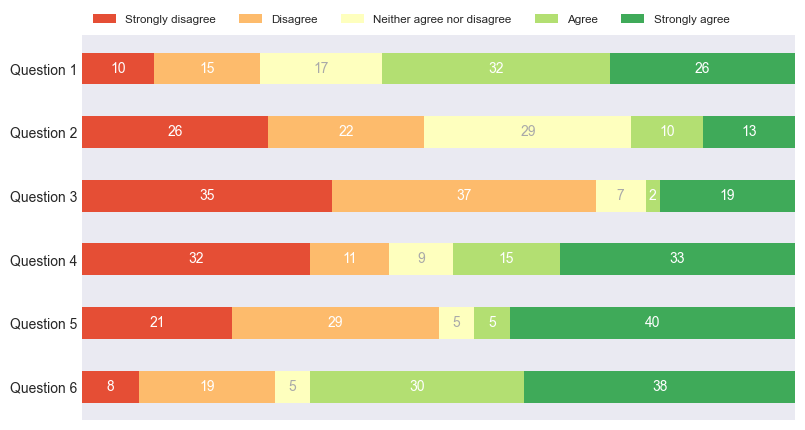

In [22]:


category_names = ['Strongly disagree', 'Disagree',
                  'Neither agree nor disagree', 'Agree', 'Strongly agree']
results = {
    'Question 1': [10, 15, 17, 32, 26],
    'Question 2': [26, 22, 29, 10, 13],
    'Question 3': [35, 37, 7, 2, 19],
    'Question 4': [32, 11, 9, 15, 33],
    'Question 5': [21, 29, 5, 5, 40],
    'Question 6': [8, 19, 5, 30, 38]
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(results, category_names)
plt.show()


##############
Antofagasta
##############
Cantidad de datos es menor a la requerida. (tmnReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región de Antofagasta', 'nomCt': 'Antofagasta', 'totRegUSD': 'US $360 millones', 'totRegCLP': '$300.199 millones', 'totRegOC': '37.739', 'totRegCLPM': '$196.516 millones', 'totRegOCM': '34.483', 'totRegPct': '52,8%', 'totRegVarPlb': 'un aumento', 'tmnRegTOTAL': '$300.199 millones', 'tmnRegindex1': 0, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Antofagasta', 'tmnReg1': 'Grande', 'tmnRegUSD1': 'US $214 millones', 'tmnRegCLP1': '$177.706 millones', 'tmnRegCLF1': '4.942.601 UF', 'tmnRegOC1': '17.551', 'tmnRegPct1': '59,2%', 'tmnRegindex2': 1, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Antofagasta', 'tmnReg2': 'MiPyme', 'tmnRegUSD2': 'US $146 millones', 'tmnRegCLP2': '$122.494 millones', 'tmnRegCLF2': '3.407.726 UF', 'tmnRegOC2': '20.188', 'tmnRegPct2': '40,8%', 'modRegTOTAL': '$300.199 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Antofagasta', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $266 millones', 'modRegC

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región de La Araucanía', 'nomCt': 'La Araucanía', 'totRegUSD': 'US $687 millones', 'totRegCLP': '$574.970 millones', 'totRegOC': '135.334', 'totRegCLPM': '$444.477 millones', 'totRegOCM': '125.818', 'totRegPct': '29,4%', 'totRegVarPlb': 'un aumento', 'tmnRegTOTAL': '$574.970 millones', 'tmnRegindex1': 1, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Araucanía', 'tmnReg1': 'MiPyme', 'tmnRegUSD1': 'US $388 millones', 'tmnRegCLP1': '$325.154 millones', 'tmnRegCLF1': '9.049.987 UF', 'tmnRegOC1': '86.174', 'tmnRegPct1': '56,6%', 'tmnRegindex2': 0, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Araucanía', 'tmnReg2': 'Grande', 'tmnRegUSD2': 'US $299 millones', 'tmnRegCLP2': '$249.816 millones', 'tmnRegCLF2': '6.950.894 UF', 'tmnRegOC2': '49.160', 'tmnRegPct2': '43,4%', 'modRegTOTAL': '$574.970 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Araucanía', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $461 millones', 'modRegCLP

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región de Arica y Parinacota', 'nomCt': 'Arica y Parinacota', 'totRegUSD': 'US $247 millones', 'totRegCLP': '$209.691 millones', 'totRegOC': '37.941', 'totRegCLPM': '$141.693 millones', 'totRegOCM': '30.452', 'totRegPct': '48,0%', 'totRegVarPlb': 'un aumento', 'tmnRegTOTAL': '$209.691 millones', 'tmnRegindex1': 0, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Arica y Parinacota', 'tmnReg1': 'Grande', 'tmnRegUSD1': 'US $138 millones', 'tmnRegCLP1': '$118.562 millones', 'tmnRegCLF1': '3.274.541 UF', 'tmnRegOC1': '16.950', 'tmnRegPct1': '56,5%', 'tmnRegindex2': 1, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Arica y Parinacota', 'tmnReg2': 'MiPyme', 'tmnRegUSD2': 'US $108 millones', 'tmnRegCLP2': '$91.129 millones', 'tmnRegCLF2': '2.533.658 UF', 'tmnRegOC2': '20.991', 'tmnRegPct2': '43,5%', 'modRegTOTAL': '$209.691 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Arica y Parinacota', 'modReg1': 'Licitación Pública', 'modRegU

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región de Atacama', 'nomCt': 'Atacama', 'totRegUSD': 'US $203 millones', 'totRegCLP': '$169.617 millones', 'totRegOC': '38.654', 'totRegCLPM': '$247.834 millones', 'totRegOCM': '35.449', 'totRegPct': '-31,6%', 'totRegVarPlb': 'una disminución', 'tmnRegTOTAL': '$169.617 millones', 'tmnRegindex1': 1, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Atacama', 'tmnReg1': 'MiPyme', 'tmnRegUSD1': 'US $108 millones', 'tmnRegCLP1': '$91.385 millones', 'tmnRegCLF1': '2.540.476 UF', 'tmnRegOC1': '23.619', 'tmnRegPct1': '53,9%', 'tmnRegindex2': 0, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Atacama', 'tmnReg2': 'Grande', 'tmnRegUSD2': 'US $94.712.416', 'tmnRegCLP2': '$78.232 millones', 'tmnRegCLF2': '2.176.769 UF', 'tmnRegOC2': '15.035', 'tmnRegPct2': '46,1%', 'modRegTOTAL': '$169.617 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Atacama', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $117 millones', 'modRegCLP1': '$98.728 mil

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región de Aysén', 'nomCt': 'Aysén', 'totRegUSD': 'US $222 millones', 'totRegCLP': '$185.815 millones', 'totRegOC': '40.724', 'totRegCLPM': '$110.679 millones', 'totRegOCM': '37.600', 'totRegPct': '67,9%', 'totRegVarPlb': 'un aumento', 'tmnRegTOTAL': '$185.815 millones', 'tmnRegindex1': 1, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Aysén', 'tmnReg1': 'MiPyme', 'tmnRegUSD1': 'US $135 millones', 'tmnRegCLP1': '$112.832 millones', 'tmnRegCLF1': '3.137.157 UF', 'tmnRegOC1': '25.549', 'tmnRegPct1': '60,7%', 'tmnRegindex2': 0, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Aysén', 'tmnReg2': 'Grande', 'tmnRegUSD2': 'US $87.640.680', 'tmnRegCLP2': '$72.984 millones', 'tmnRegCLF2': '2.046.486 UF', 'tmnRegOC2': '15.175', 'tmnRegPct2': '39,3%', 'modRegTOTAL': '$185.815 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Aysén', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $161 millones', 'modRegCLP1': '$134.398 millones', 'modRe

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región del Bío-Bío', 'nomCt': 'el Bío-Bío', 'totRegUSD': 'US $950 millones', 'totRegCLP': '$792.963 millones', 'totRegOC': '170.999', 'totRegCLPM': '$694.594 millones', 'totRegOCM': '162.300', 'totRegPct': '14,2%', 'totRegVarPlb': 'un aumento', 'tmnRegTOTAL': '$792.963 millones', 'tmnRegindex1': 1, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Bío-Bío', 'tmnReg1': 'MiPyme', 'tmnRegUSD1': 'US $478 millones', 'tmnRegCLP1': '$399.974 millones', 'tmnRegCLF1': '11.124.331 UF', 'tmnRegOC1': '102.470', 'tmnRegPct1': '50,4%', 'tmnRegindex2': 0, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Bío-Bío', 'tmnReg2': 'Grande', 'tmnRegUSD2': 'US $472 millones', 'tmnRegCLP2': '$392.990 millones', 'tmnRegCLF2': '10.941.980 UF', 'tmnRegOC2': '68.529', 'tmnRegPct2': '49,6%', 'modRegTOTAL': '$792.963 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Bío-Bío', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $641 millones', 'modRegCLP1': '$535

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región de Coquimbo', 'nomCt': 'Coquimbo', 'totRegUSD': 'US $377 millones', 'totRegCLP': '$315.200 millones', 'totRegOC': '73.031', 'totRegCLPM': '$329.752 millones', 'totRegOCM': '69.346', 'totRegPct': '-4,4%', 'totRegVarPlb': 'una disminución', 'tmnRegTOTAL': '$315.200 millones', 'tmnRegindex1': 1, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Coquimbo', 'tmnReg1': 'MiPyme', 'tmnRegUSD1': 'US $208 millones', 'tmnRegCLP1': '$174.343 millones', 'tmnRegCLF1': '4.850.432 UF', 'tmnRegOC1': '47.219', 'tmnRegPct1': '55,3%', 'tmnRegindex2': 0, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Coquimbo', 'tmnReg2': 'Grande', 'tmnRegUSD2': 'US $169 millones', 'tmnRegCLP2': '$140.857 millones', 'tmnRegCLF2': '3.924.127 UF', 'tmnRegOC2': '25.812', 'tmnRegPct2': '44,7%', 'modRegTOTAL': '$315.200 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Coquimbo', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $258 millones', 'modRegCLP1': '$21

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': "Región de O'Higgins", 'nomCt': "O'Higgins", 'totRegUSD': 'US $393 millones', 'totRegCLP': '$328.490 millones', 'totRegOC': '85.482', 'totRegCLPM': '$337.993 millones', 'totRegOCM': '81.052', 'totRegPct': '-2,8%', 'totRegVarPlb': 'una disminución', 'tmnRegTOTAL': '$328.490 millones', 'tmnRegindex1': 1, 'tmnRegAno1': 2023, 'tmnRegRegion1': "Lib. Gral. Bdo. O'Higgins", 'tmnReg1': 'MiPyme', 'tmnRegUSD1': 'US $255 millones', 'tmnRegCLP1': '$214.031 millones', 'tmnRegCLF1': '5.956.613 UF', 'tmnRegOC1': '59.590', 'tmnRegPct1': '65,2%', 'tmnRegindex2': 0, 'tmnRegAno2': 2023, 'tmnRegRegion2': "Lib. Gral. Bdo. O'Higgins", 'tmnReg2': 'Grande', 'tmnRegUSD2': 'US $138 millones', 'tmnRegCLP2': '$114.459 millones', 'tmnRegCLF2': '3.190.674 UF', 'tmnRegOC2': '25.892', 'tmnRegPct2': '34,8%', 'modRegTOTAL': '$328.490 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': "Lib. Gral. Bdo. O'Higgins", 'modReg1': 'Licitación Pública',

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región de Los Lagos', 'nomCt': 'Los Lagos', 'totRegUSD': 'US $523 millones', 'totRegCLP': '$435.882 millones', 'totRegOC': '123.802', 'totRegCLPM': '$398.602 millones', 'totRegOCM': '114.383', 'totRegPct': '9,4%', 'totRegVarPlb': 'un aumento', 'tmnRegTOTAL': '$435.882 millones', 'tmnRegindex1': 1, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Los Lagos', 'tmnReg1': 'MiPyme', 'tmnRegUSD1': 'US $286 millones', 'tmnRegCLP1': '$238.942 millones', 'tmnRegCLF1': '6.654.038 UF', 'tmnRegOC1': '74.423', 'tmnRegPct1': '54,8%', 'tmnRegindex2': 0, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Los Lagos', 'tmnReg2': 'Grande', 'tmnRegUSD2': 'US $237 millones', 'tmnRegCLP2': '$196.940 millones', 'tmnRegCLF2': '5.484.545 UF', 'tmnRegOC2': '49.379', 'tmnRegPct2': '45,2%', 'modRegTOTAL': '$435.882 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Los Lagos', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $350 millones', 'modRegCLP1': '$2

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región de Los Ríos', 'nomCt': 'Los Ríos', 'totRegUSD': 'US $340 millones', 'totRegCLP': '$281.544 millones', 'totRegOC': '66.845', 'totRegCLPM': '$235.835 millones', 'totRegOCM': '60.016', 'totRegPct': '19,4%', 'totRegVarPlb': 'un aumento', 'tmnRegTOTAL': '$281.544 millones', 'tmnRegindex1': 1, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Los Ríos', 'tmnReg1': 'MiPyme', 'tmnRegUSD1': 'US $172 millones', 'tmnRegCLP1': '$143.621 millones', 'tmnRegCLF1': '3.997.072 UF', 'tmnRegOC1': '43.294', 'tmnRegPct1': '51,0%', 'tmnRegindex2': 0, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Los Ríos', 'tmnReg2': 'Grande', 'tmnRegUSD2': 'US $168 millones', 'tmnRegCLP2': '$137.923 millones', 'tmnRegCLF2': '3.840.961 UF', 'tmnRegOC2': '23.551', 'tmnRegPct2': '49,0%', 'modRegTOTAL': '$281.544 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Los Ríos', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $272 millones', 'modRegCLP1': '$224.323

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize =(10, 9))



##############
Magallanes y Antártica
##############
Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región de Magallanes y la Antártica', 'nomCt': 'Magallanes', 'totRegUSD': 'US $237 millones', 'totRegCLP': '$200.028 millones', 'totRegOC': '48.502', 'totRegCLPM': '$148.005 millones', 'totRegOCM': '44.244', 'totRegPct': '35,1%', 'totRegVarPlb': 'un aumento', 'tmnRegTOTAL': '$200.028 millones', 'tmnRegindex1': 0, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Magallanes y Antártica', 'tmnReg1': 'Grande', 'tmnRegUSD1': 'US $138 millones', 'tmnRegCLP1': '$117.672 millones', 'tmnRegCLF1': '3.266.180 UF', 'tmnRegOC1': '23.091', 'tmnRegPct1': '58,8%', 'tmnRegindex2': 1, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Magallanes y Antártica', 'tmnReg2': 'MiPyme', 'tmnRegUSD2': 'US $98.111.728', 'tmnRegCLP2': '$82.356 millones', 'tmnRegCLF2': '2.290.862 UF', 'tmnRegOC2': '25.411', 'tmnRegPct2': '41,2%', 'modRegTOTAL': '$200.028 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Magallanes y Antártica', 'modReg1': 'Licitación Pública',

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región del Maule', 'nomCt': 'el Maule', 'totRegUSD': 'US $661 millones', 'totRegCLP': '$552.959 millones', 'totRegOC': '136.789', 'totRegCLPM': '$396.787 millones', 'totRegOCM': '127.500', 'totRegPct': '39,4%', 'totRegVarPlb': 'un aumento', 'tmnRegTOTAL': '$552.959 millones', 'tmnRegindex1': 1, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Maule', 'tmnReg1': 'MiPyme', 'tmnRegUSD1': 'US $358 millones', 'tmnRegCLP1': '$298.932 millones', 'tmnRegCLF1': '8.323.948 UF', 'tmnRegOC1': '87.033', 'tmnRegPct1': '54,1%', 'tmnRegindex2': 0, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Maule', 'tmnReg2': 'Grande', 'tmnRegUSD2': 'US $304 millones', 'tmnRegCLP2': '$254.027 millones', 'tmnRegCLF2': '7.058.533 UF', 'tmnRegOC2': '49.756', 'tmnRegPct2': '45,9%', 'modRegTOTAL': '$552.959 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Maule', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $491 millones', 'modRegCLP1': '$410.037 millones

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (tmnReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región Metropolitana', 'nomCt': 'la R. Metropolitana', 'totRegUSD': 'US $7.714 millones', 'totRegCLP': '$6.416.775 millones', 'totRegOC': '501.245', 'totRegCLPM': '$6.386.589 millones', 'totRegOCM': '425.820', 'totRegPct': '0,5%', 'totRegVarPlb': 'un aumento', 'tmnRegTOTAL': '$6.416.775 millones', 'tmnRegindex1': 0, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Metropolitana', 'tmnReg1': 'Grande', 'tmnRegUSD1': 'US $5.516 millones', 'tmnRegCLP1': '$4.576.676 millones', 'tmnRegCLF1': '128 millones de UF', 'tmnRegOC1': '253.031', 'tmnRegPct1': '71,3%', 'tmnRegindex2': 1, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Metropolitana', 'tmnReg2': 'MiPyme', 'tmnRegUSD2': 'US $2.198 millones', 'tmnRegCLP2': '$1.840.099 millones', 'tmnRegCLF2': '51.215.467 UF', 'tmnRegOC2': '248.214', 'tmnRegPct2': '28,7%', 'modRegTOTAL': '$6.416.775 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Metropolitana', 'modReg1': 'Licitación Pública', '

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región del Ñuble', 'nomCt': 'el Ñuble', 'totRegUSD': 'US $321 millones', 'totRegCLP': '$270.768 millones', 'totRegOC': '79.422', 'totRegCLPM': '$224.794 millones', 'totRegOCM': '73.911', 'totRegPct': '20,5%', 'totRegVarPlb': 'un aumento', 'tmnRegTOTAL': '$270.768 millones', 'tmnRegindex1': 1, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Ñuble', 'tmnReg1': 'MiPyme', 'tmnRegUSD1': 'US $177 millones', 'tmnRegCLP1': '$148.367 millones', 'tmnRegCLF1': '4.126.631 UF', 'tmnRegOC1': '56.060', 'tmnRegPct1': '54,8%', 'tmnRegindex2': 0, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Ñuble', 'tmnReg2': 'Grande', 'tmnRegUSD2': 'US $144 millones', 'tmnRegCLP2': '$122.401 millones', 'tmnRegCLF2': '3.399.235 UF', 'tmnRegOC2': '23.362', 'tmnRegPct2': '45,2%', 'modRegTOTAL': '$270.768 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Ñuble', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $237 millones', 'modRegCLP1': '$199.912 millones',

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región de Tarapacá', 'nomCt': 'Tarapacá', 'totRegUSD': 'US $202 millones', 'totRegCLP': '$169.678 millones', 'totRegOC': '37.662', 'totRegCLPM': '$211.694 millones', 'totRegOCM': '32.809', 'totRegPct': '-19,8%', 'totRegVarPlb': 'una disminución', 'tmnRegTOTAL': '$169.678 millones', 'tmnRegindex1': 1, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Tarapacá', 'tmnReg1': 'MiPyme', 'tmnRegUSD1': 'US $120 millones', 'tmnRegCLP1': '$101.286 millones', 'tmnRegCLF1': '2.814.181 UF', 'tmnRegOC1': '21.581', 'tmnRegPct1': '59,7%', 'tmnRegindex2': 0, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Tarapacá', 'tmnReg2': 'Grande', 'tmnRegUSD2': 'US $81.502.191', 'tmnRegCLP2': '$68.392 millones', 'tmnRegCLF2': '1.903.176 UF', 'tmnRegOC2': '16.081', 'tmnRegPct2': '40,3%', 'modRegTOTAL': '$169.678 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Tarapacá', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $127 millones', 'modRegCLP1': '$106.

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10996\4125630173.py:219: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)
{'nom': 'Región de Valparaíso', 'nomCt': 'Valparaíso', 'totRegUSD': 'US $1.205 millones', 'totRegCLP': '$1.004.857 millones', 'totRegOC': '189.983', 'totRegCLPM': '$902.335 millones', 'totRegOCM': '171.086', 'totRegPct': '11,4%', 'totRegVarPlb': 'un aumento', 'tmnRegTOTAL': '$1.004.857 millones', 'tmnRegindex1': 0, 'tmnRegAno1': 2023, 'tmnRegRegion1': 'Valparaíso', 'tmnReg1': 'Grande', 'tmnRegUSD1': 'US $620 millones', 'tmnRegCLP1': '$516.664 millones', 'tmnRegCLF1': '14.388.652 UF', 'tmnRegOC1': '73.548', 'tmnRegPct1': '51,4%', 'tmnRegindex2': 1, 'tmnRegAno2': 2023, 'tmnRegRegion2': 'Valparaíso', 'tmnReg2': 'MiPyme', 'tmnRegUSD2': 'US $585 millones', 'tmnRegCLP2': '$488.193 millones', 'tmnRegCLF2': '13.586.877 UF', 'tmnRegOC2': '116.435', 'tmnRegPct2': '48,6%', 'modRegTOTAL': '$1.004.857 millones', 'modRegindex1': 3, 'modRegAno1': 2023, 'modRegRegion1': 'Valparaíso', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $787 millones', 

<Figure size 640x480 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

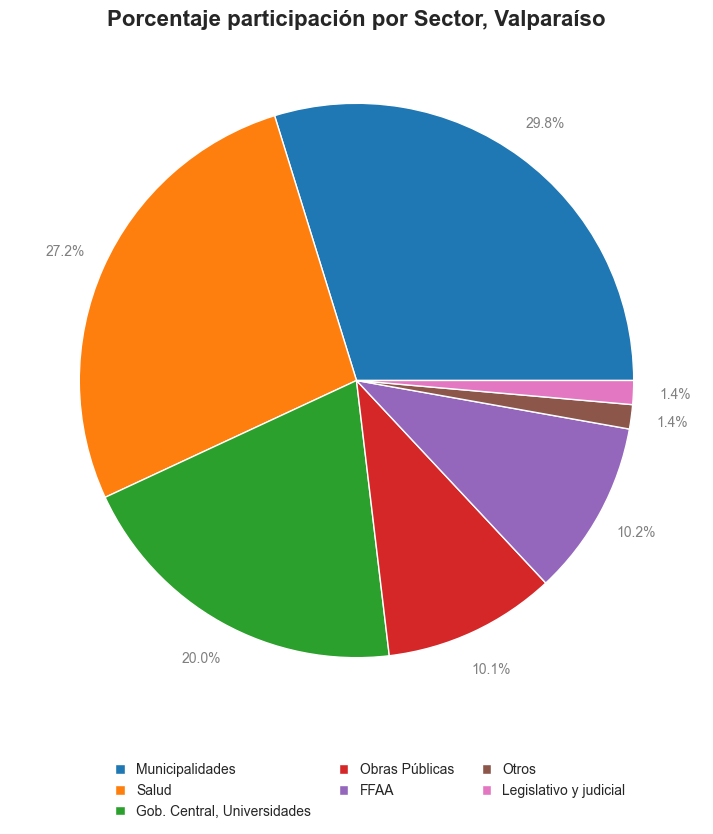

In [23]:
###################################################
###   Llenado diccionario/contexto y template   ###
###################################################

#Importar template
docu = DocxTemplate("docxtpl.docx")

#Settear diccionario nacional
contextoNac = {'ano' : str(anoReg),
               'anoM' : str(anoRegM),
               'mesI' : meses[mes_i - 1],   #llama nombre del mes para usar en reporte
               'mesF' : meses[mes_f - 1]}

#settear diccionario adicionales regionales
adicionalesReg = impAdicionalesReg()

dicGlob = {}



#Iterador de regiones/documentos
for r in listReg:
    print('')
    print('##############')
    print(r)
    print('##############')

    contexto = setContextoReg(r)

    rTotReg = TotReg.loc[TotReg['Region'] == r]
    contexto.update(agregarTotalesRegion(rTotReg))

    #tmn Reg
    rTmnReg = extraerDataframe (TotRegBig, r, listColTmnReg)
    rTmnReg = fmtoDataframe(rTmnReg, listColTmnReg)
    contexto.update(dataframeDiciconario(rTmnReg, dtoTmnReg))

    #modalidad de compra
    rModReg = extraerDataframe (TotRegBig, r, listColModReg)
    rModReg = fmtoDataframe(rModReg, listColModReg)    
    contexto.update(dataframeDiciconario(rModReg, dtoModReg))

    
    # proveedores a los que se le compra por región
    rPrvReg = extraerDataframe (TotRegBig, r, listColPrvReg)
    rPrvReg = fmtoDataframe(rPrvReg, listColPrvReg) 
    contexto.update(dataframeDiciconario(rPrvReg, dtoPrvReg))

    # top Instituciones reg
    rInsReg = extraerDataframe (TotRegBig, r, listColInsReg)
    rInsReg = fmtoDataframe(rInsReg, listColInsReg)    
    contexto.update(dataframeDiciconario(rInsReg, dtoInsReg))

    #top rubro por region (usa dataframe personalizado)
    rRubReg = extraerDataframe(RubReg, r, listColRubReg)
    rRubReg = fmtoDataframe(rRubReg, listColRubReg)
    
    ttlGrafRub = 'Rubros más transados, '+ RegNomb[r]['nomCt']+' (Millones de Pesos)'
    grafBarras((np.array(rRubReg['CLP'])/1000000), rRubReg[''], ttlGrafRub)
    img = InlineImage(docu, ttlGrafRub+'.png',width=Inches(7))
    contexto.update({'rubRegGrf' : img})

    #no lo pide ahora comunicaciones
    #contexto.update(dataframeDiciconario(rRubReg, dtoRubReg, topRubReg))
    
    rOCReg = extraerDataframe(TotRegBig, r, listColOCReg)
    rOCReg = fmtoDataframe(rOCReg, listColOCReg)
    contexto.update(dataframeDiciconario(rOCReg, dtoOCReg))

    rSecReg = extraerDataframe(TotRegBig, r, listColSecReg)
    rSecReg = fmtoDataframe(rSecReg, listColSecReg)
    contexto.update(dataframeDiciconario(rSecReg, dtoSecReg))

    ttlGrafSec = 'Porcentaje participación por Sector, '+ RegNomb[r]['nomCt']
    grafTorta(rSecReg['CLP'], rSecReg[''], ttlGrafSec)
    img = InlineImage(docu, ttlGrafSec+'.png',width=Inches(7))
    contexto.update({'secRegGrf' : img})

    rCAReg = CAReg.loc[CAReg['Region'] == r]
    contexto.update(agregarCARegion(rCAReg))

    contexto.update(adicionalesReg[r])

    contexto.update(contextoNac)
    
    
    print(contexto)
    dicGlob.update({r: contexto})

    docu.render(contexto)
    #os.remove(titGrafSecReg +'.png')    #según cantidad de gráficos se podría iterar
    
    nomDocu = contexto['ano'] + ' cifras regionales ' + contexto['nomCt'] + ' ' + contexto['mesI'] + '-' + contexto['mesF']
    docu.save('reportes/'+nomDocu+'.docx')

In [24]:
#######################################################
# Exporta planilla con todos los contextos regionales #
#######################################################

dfGlob = pd.DataFrame(dicGlob)
dfGlob.to_excel('dfGlob.xlsx')

In [25]:
#############################
# Borar gráficos de carptea #
#############################

for r in listReg:
    
    os.remove('Rubros más transados, '+ RegNomb[r]['nomCt']+' (Millones de Pesos)' +'.png')   
    os.remove('Porcentaje participación por Sector, '+ RegNomb[r]['nomCt'] +'.png')   